# Library install

In [1]:
pip install nibabel pandas numpy scipy openpyxl imageio

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Preprocessing

# 0. Import Library

In [18]:
import os
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage import filters, morphology, img_as_float
from skimage.filters import gaussian


## 1. Load Data

In [3]:
# 경로 설정
data_dir = "../dataset/"
excel_file_path = data_dir+"oasis_cross-sectional-5708aa0a98d82080.xlsx"

In [14]:
# 엑셀 파일에서 인구통계학적 정보를 데이터프레임으로 로드 - 모든 정보를 가져옴
df = pd.read_excel(excel_file_path)
df = df[['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Delay']]

# CDR 값이 없는 경우, 결측값으로 간주하고 제거
df = df.dropna(subset=['CDR'])

In [15]:
# MRI, label, 인구통계 정보를 위한 리스트와 딕셔너리 생성
coronal_images = {}
sagittal_images = {}
transverse_images_gfc = {}
transverse_images_masked = {}
labels = []
demographics = {}

In [6]:
# 이미지 크기 조정 함수 정의 (이미지를 224x224로 변환)
def resize_image(image, new_shape=(224, 224)):
    current_shape = image.shape[:2]  # 2D 이미지이므로 앞의 두 차원만 사용
    zoom_factors = [n / c for n, c in zip(new_shape, current_shape)]
    return zoom(image, zoom_factors)

In [19]:
# 피험자 ID와 df 값을 매칭하여 딕셔너리에 저장하는 함수
def save_dictionary(subject_id):
    # 엑셀에서 해당 ID를 매칭하고 정보를 찾기
    subject_info = df[df['ID'] == subject_id]

    if not subject_info.empty:
        # CDR 값을 label로 사용
        cdr_value = subject_info['CDR'].values[0]
        labels.append(cdr_value)

        # 인구통계학적 정보 딕셔너리에 저장
        demographics[subject_id] = {
            'M/F': subject_info['M/F'].values[0],
            'Hand': subject_info['Hand'].values[0],
            'Age': subject_info['Age'].values[0],
            'Educ': subject_info['Educ'].values[0],
            'SES': subject_info['SES'].values[0],
            'MMSE': subject_info['MMSE'].values[0],
            'eTIV': subject_info['eTIV'].values[0],
            'nWBV': subject_info['nWBV'].values[0],
            'ASF': subject_info['ASF'].values[0],
            'Delay': subject_info['Delay'].values[0]
        }
    else:
        print(f"Label not found for subject: {subject_id}")  # label이 없는 피험자 출력

In [28]:
# 두개골 제거 함수
def skull_strip(image):
    
    # Gaussian 필터 적용 (노이즈 제거)
    smoothed_image = gaussian(image, sigma=1)

    # Otsu의 방법으로 threshold 설정
    threshold_value = filters.threshold_otsu(smoothed_image)
    skull_mask = smoothed_image > threshold_value  # 두개골 마스크 생성

    # 모폴로지 연산 (열림 연산)으로 마스크 개선
    skull_mask_cleaned = morphology.opening(skull_mask, morphology.disk(2))

    # 최종 이미지를 생성
    stripped_image = np.where(skull_mask_cleaned, image, 0)  # 두개골 부분 제거
    
    return stripped_image


In [29]:
# 시각화 함수
def visualize_images(original, masked, stripped, title1="Original Image", title2="Masked Image", title3="Stripped Image"):
    plt.figure(figsize=(18, 6))
    
    # 원본
    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title(title1)
    plt.axis('off')

    # mask 이미지
    plt.subplot(1, 3, 2)
    plt.imshow(masked, cmap='gray')
    plt.title(title2)
    plt.axis('off')

    # stripped 이미지
    plt.subplot(1, 3, 3)
    plt.imshow(stripped, cmap='gray')
    plt.title(title3)
    plt.axis('off')

    plt.show()

In [30]:
# 피험자 데이터 로드 및 저장
for disc_num in range(1, 13):  # 1~12 디스크 (OASIS 디스크 12개)
    disc_path = os.path.join(data_dir, f"oasis_cross-sectional_disc{disc_num}")

    # [디버깅] 디스크 경로가 존재하는지 확인
    if not os.path.exists(disc_path):
        print(f"Disc path does not exist: {disc_path}")
        continue

    for sub_folder in os.listdir(disc_path):  # disc 안의 폴더 탐색
        sub_folder_path = os.path.join(disc_path, sub_folder)

        if not os.path.isdir(sub_folder_path):  # [디버깅] 폴더가 아닌 경우 무시
            print(f"Skipping non-directory: {sub_folder_path}")
            continue

        for subject_dir in os.listdir(sub_folder_path):  # 피험자 폴더 탐색
            subject_path = os.path.join(sub_folder_path, subject_dir)

            if not os.path.isdir(subject_path):  # [디버깅] 폴더가 아닌 경우 무시
                print(f"Skipping non-directory: {subject_path}")
                continue

            # MR1 경로 설정
            session_path = subject_path
            print(f"Processing session: {session_path}")

            if not os.path.exists(session_path):  # [디버깅]
                print(f"Session path does not exist: {session_path}")
                continue

            # preprocessed 데이터 경로 (T88_111 폴더)
            t88_111_path = os.path.join(session_path, "PROCESSED", "MPRAGE", "T88_111")
            print(f"Checking T88_111 path: {t88_111_path}")

            if os.path.exists(t88_111_path):
                for file in os.listdir(t88_111_path):
                    file_path = os.path.join(t88_111_path, file)

                    # masked transverse 이미지 처리
                    if "masked_gfc" in file and file.endswith("_tra_90.gif"):
                        print(f"Loading masked transverse .gif file: {file_path}")
                        try:
                            img_masked = imageio.v2.imread(file_path)
                            img_masked_resized = resize_image(img_masked)
                            transverse_images_masked[subject_dir] = img_masked_resized
                        except Exception as e:  # [디버깅]
                            print(f"Error loading masked transverse image: {e}")

                    # regular transverse 이미지 처리
                    elif file.endswith("_tra_90.gif"):
                        print(f"Loading regular transverse .gif file: {file_path}")
                        try:
                            img = imageio.v2.imread(file_path)
                            img_resized = resize_image(img)
                            transverse_images_gfc[subject_dir] = img_resized

                            # 두개골 제거 후 이미지 생성
                            stripped_image = skull_strip(img_resized)  # 두개골 제거
                            transverse_images_gfc[subject_dir + "_stripped"] = stripped_image  # 제거된 이미지 저장
                        except Exception as e:  # [디버깅]
                            print(f"Error loading regular transverse image: {e}")

                    # 피험자 ID 그대로 추출
                    subject_id = subject_dir

                    # 피험자 ID와 엑셀 파일상 데이터 매칭하여 딕셔너리에 저장
                    save_dictionary(subject_id)
            else:
                print(f"T88_111 path does not exist: {t88_111_path}")

Skipping non-directory: ../dataset/oasis_cross-sectional_disc1/.DS_Store
Skipping non-directory: ../dataset/oasis_cross-sectional_disc1/disc1/.DS_Store
Processing session: ../dataset/oasis_cross-sectional_disc1/disc1/OAS1_0016_MR1
Checking T88_111 path: ../dataset/oasis_cross-sectional_disc1/disc1/OAS1_0016_MR1/PROCESSED/MPRAGE/T88_111
Loading masked transverse .gif file: ../dataset/oasis_cross-sectional_disc1/disc1/OAS1_0016_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0016_MR1_mpr_n3_anon_111_t88_masked_gfc_tra_90.gif
Loading regular transverse .gif file: ../dataset/oasis_cross-sectional_disc1/disc1/OAS1_0016_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0016_MR1_mpr_n3_anon_111_t88_gfc_tra_90.gif
Processing session: ../dataset/oasis_cross-sectional_disc1/disc1/OAS1_0002_MR1
Checking T88_111 path: ../dataset/oasis_cross-sectional_disc1/disc1/OAS1_0002_MR1/PROCESSED/MPRAGE/T88_111
Loading masked transverse .gif file: ../dataset/oasis_cross-sectional_disc1/disc1/OAS1_0002_MR1/PROCESSED/MPRAGE/T88_111/OAS1_00

## 2. Skull Stripping

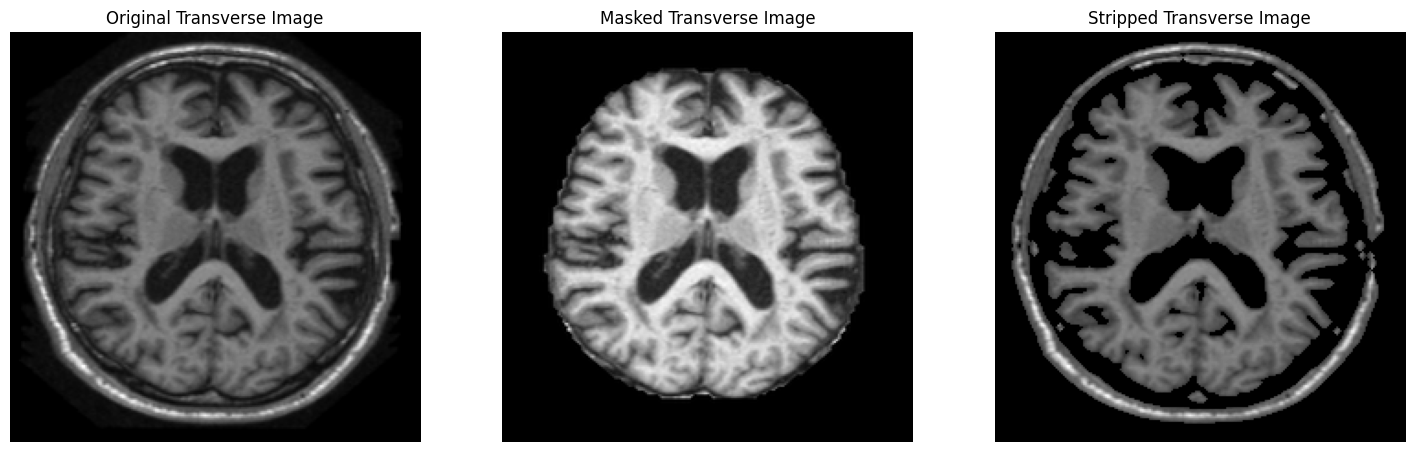

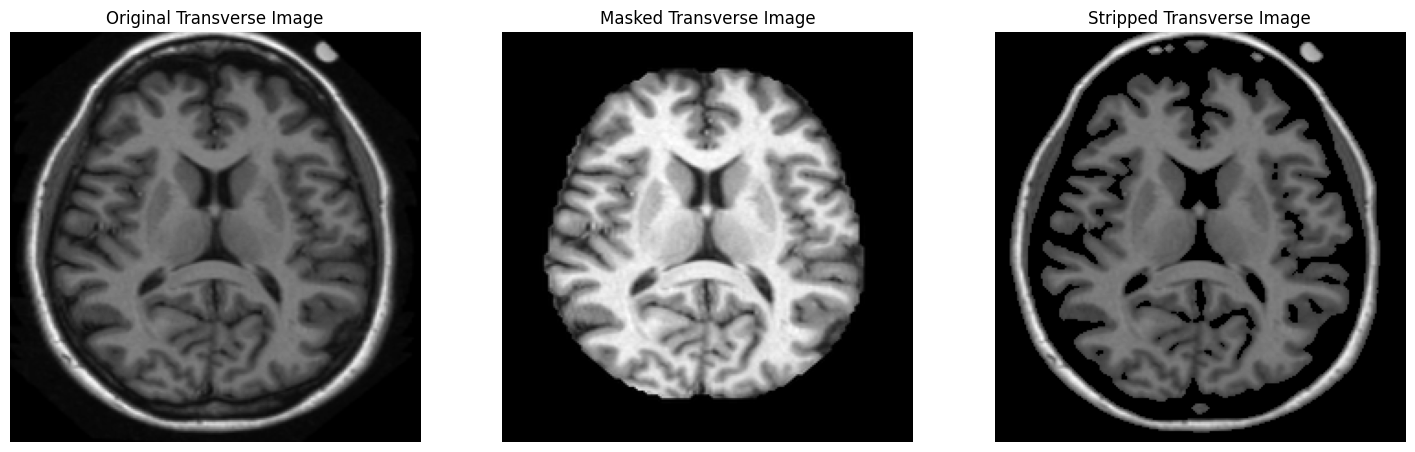

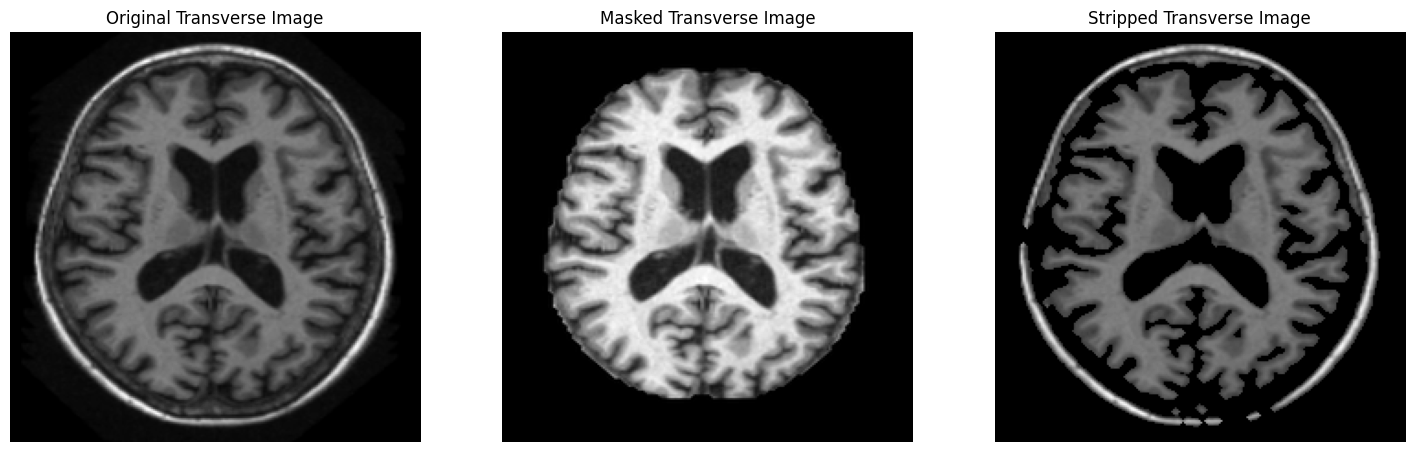

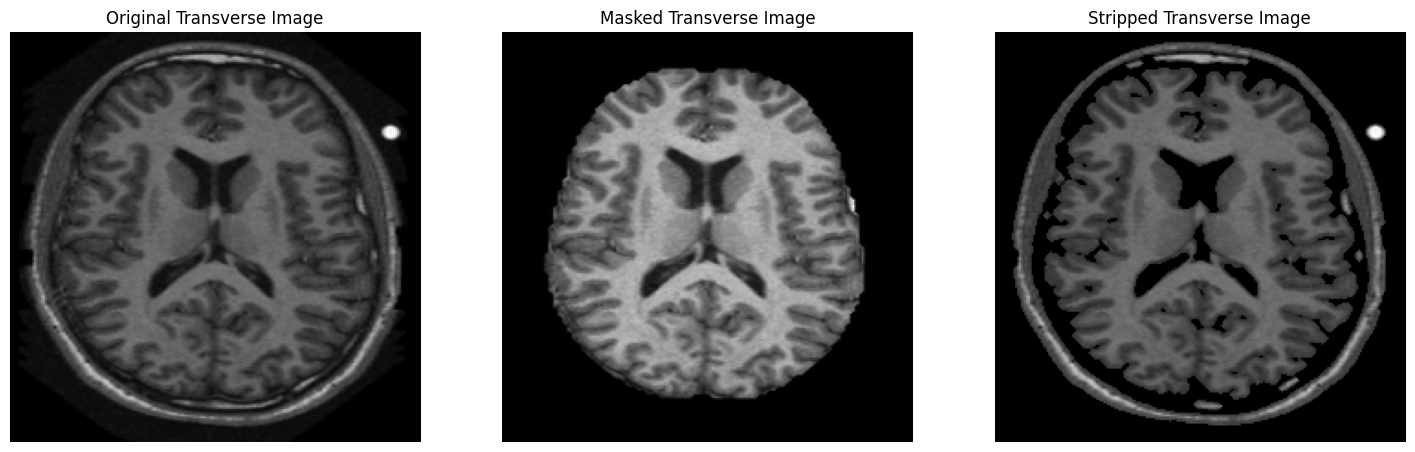

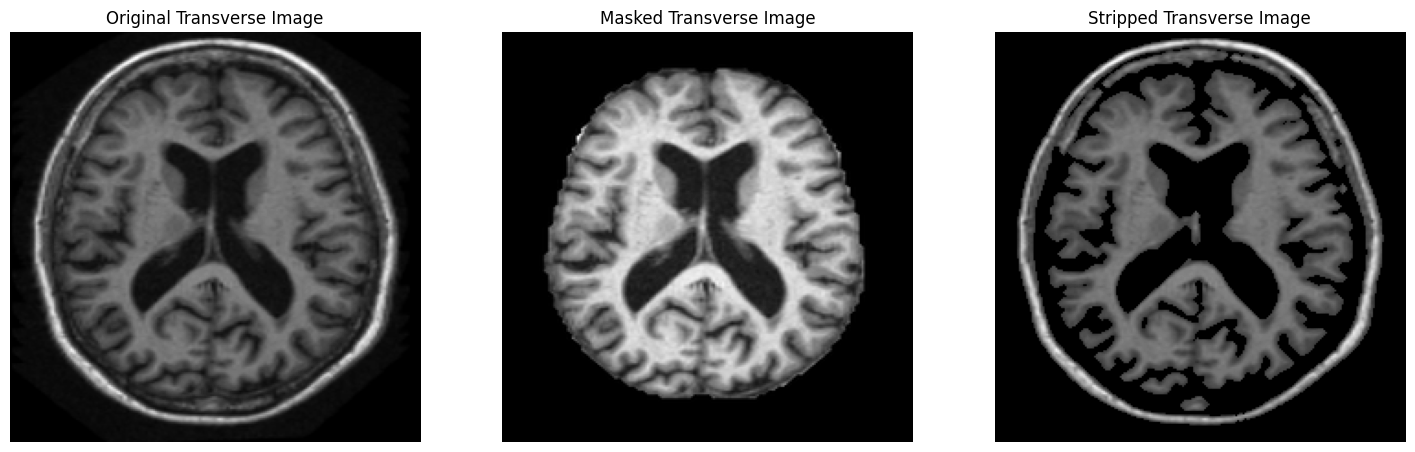

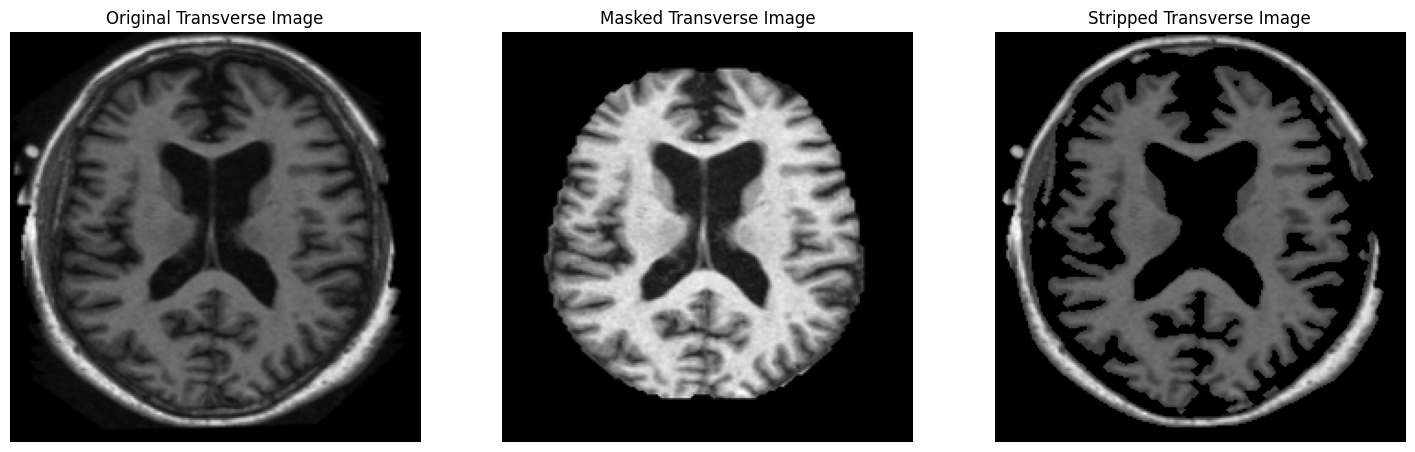

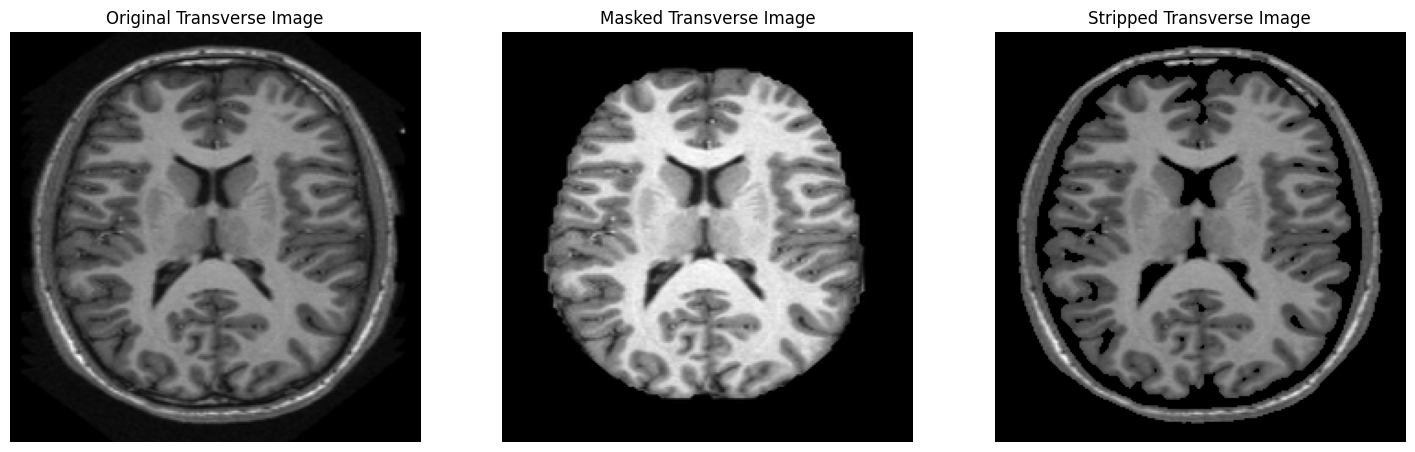

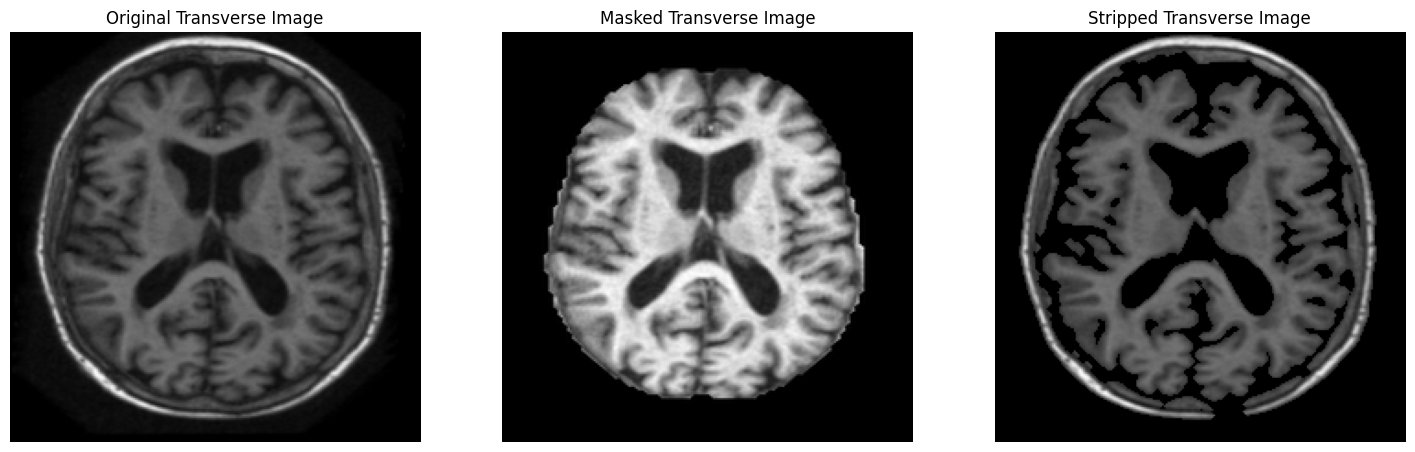

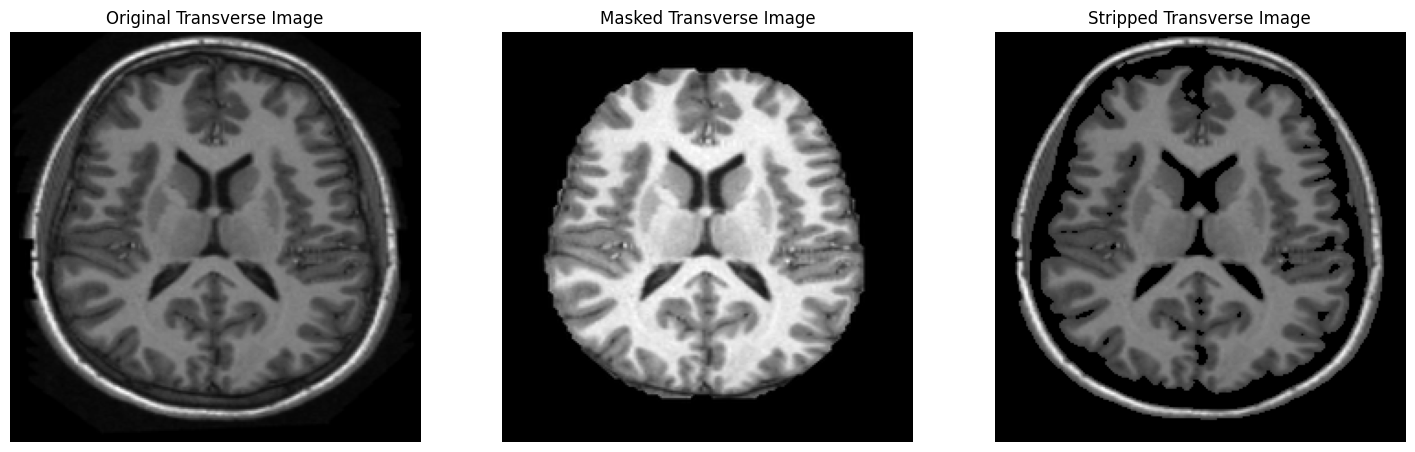

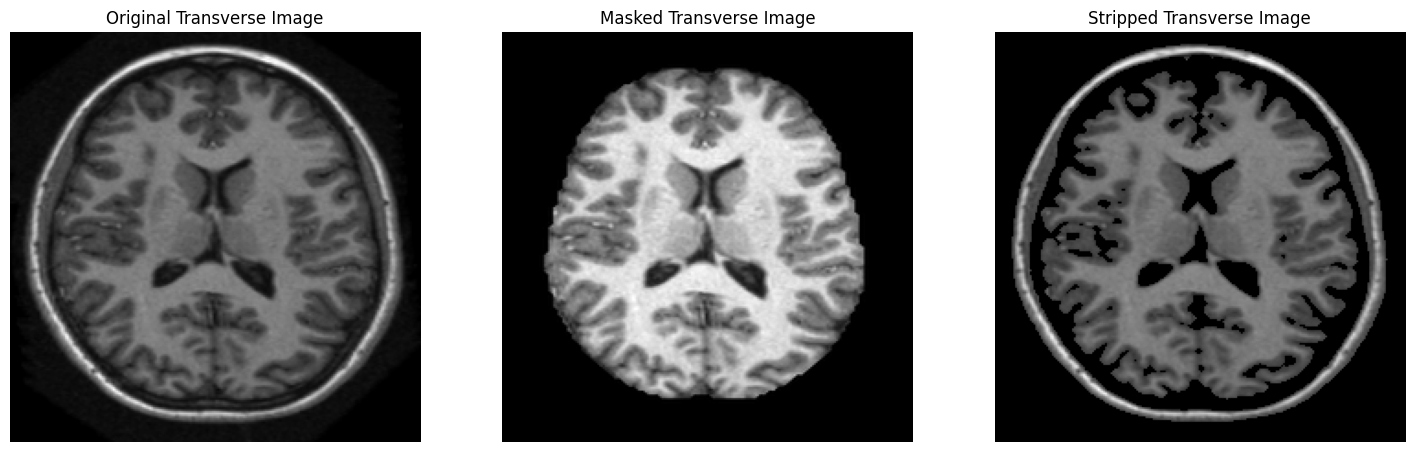

In [31]:
# 시각화 예시 (10개 피험자만)
count = 0
max_subjects_to_visualize = 10  # 시각화할 최대 피험자 수

for subject_id in transverse_images_gfc.keys():
    if subject_id in transverse_images_masked:
        original_image = transverse_images_gfc[subject_id]  # 원본 이미지
        masked_image = transverse_images_masked[subject_id]  # masked 이미지
        stripped_image = transverse_images_gfc[subject_id + "_stripped"]  # 두개골 제거된 이미지
        
        # 이미지 시각화
        visualize_images(original_image, masked_image, stripped_image, 
                         title1="Original Transverse Image", 
                         title2="Masked Transverse Image", 
                         title3="Stripped Transverse Image")
        
        count += 1
        if count >= max_subjects_to_visualize:  # 최대 피험자 수에 도달하면 종료
            break